# Scenario Generation
The scenarios are not directly related optimization algorithm. They can be considered as just an input data.

Time period T = 6. The number of risky assets n = 2. The number of Monte-Carlo paths I = 10000.

In [1]:
import numpy as np
from numpy.random import *
from pulp import *
from itertools import product
import matplotlib.pyplot as plt
import time
np.random.seed(1)

n = 2      # the number of risky asset
T = 6      # the number of time
nT = n * T
I = 10000    # the number of Monte-Carlo paths
IT_1 = I * (T-1)

r = 0.01
gamma = 20.0
initial_wealth = 100
target_wealth = 100

# scenario generation
mu = [0.03, 0.04]                    
s1 = 0.1
s2 = 0.2
rho = -0.5
sigma = [[s1**2, s1*s2*rho], [s1*s2*rho, s2**2]]   # n * n

returns = multivariate_normal(mu, sigma, I * T)
returns = returns.reshape(I, T, n)   # [I, T, n]
returns = returns.transpose(0, 2, 1) # [I, n, T]

prices = np.ones([I, n, T+1])
for t in range(T):
    prices[:, :, t+1] = (1 + returns[:, :, t]) * prices[:, :, t]  # element-wise multiplication

## Introducing a strategy branchpoint at t = 3

In [2]:
branch_t = 3
A_list = (np.where(np.mean(np.mean(returns[:, :, :branch_t], axis=2), axis=1) - np.mean(mu) >= 0.0))[0] # set of indices in branch A
B_list = (np.where(np.mean(np.mean(returns[:, :, :branch_t], axis=2), axis=1) - np.mean(mu) <  0.0))[0] # set of indices in branch B
A_Bool = np.mean(np.mean(returns[:, :, :branch_t], axis=2), axis=1) - np.mean(mu) >= 0.0
B_Bool = np.mean(np.mean(returns[:, :, :branch_t], axis=2), axis=1) - np.mean(mu) < 0.0

## Main Function

In [3]:
def PortfolioOptimize(prices, r, gamma, initial_wealth, target_wealth, previous_wealth, branch_t, A_list, B_list):
    I = prices.shape[0]
    n = prices.shape[1]
    T = prices.shape[2] - 1
    nT_prod   = list(product(range(n),range(T)))
    IT_1_prod = list(product(range(I),range(T-1)))
    
    # Problem Setting (Maximization)
    problem = LpProblem("PortfolioOptimization", sense=LpMaximize)

    # Setting Variables
    units_0  = {(i,j):LpVariable('units_0_%d_%d'%(i,j), lowBound=0) for i in range(n) for j in range(branch_t)} # n * branch_t
    units_A  = {(i,j):LpVariable('units_A_%d_%d'%(i,j), lowBound=0) for i in range(n) for j in range(T - branch_t)} # n * (T - branch_t)
    units_B  = {(i,j):LpVariable('units_B_%d_%d'%(i,j), lowBound=0) for i in range(n) for j in range(T - branch_t)} # n * (T - branch_t)
    
    cash_0 = LpVariable('cash_0', lowBound=0)                                         # 1 (scalor)
    cash_t = {(i,j):LpVariable('cash_t%d_%d'%(i,j), lowBound=0) for i,j in IT_1_prod} # I * (T-1)
    q      = { i   :LpVariable('q%d'%i, lowBound=0) for i in range(I)}                # I

    # Setting coefficients depending on whether it is the initial fixed-units problem, 
    #                                        or it is the iterative process using the previous_wealth
    price_coef_0 = np.zeros([I, n, T])
    price_coef_1 = np.zeros([I, n, T]) 
    if np.any(previous_wealth == None):              # initial fixed-units problem
        for t in range(T):
            price_coef_0[:, :, t] = prices[:, :, t]
            price_coef_1[:, :, t] = prices[:, :, t + 1]
    else:                                            # iterative process using the previous_wealth
        for j in range(n):
            price_coef_0[:, j, :] = previous_wealth[:, :T] # removing the last column
        for t in range(T):
            price_coef_1[:, :, t] = prices[:, :, t + 1] / prices[:, :, t] * previous_wealth[:, [t]]
                
    # Setting Objective Function
    prices_Alist_T = np.sum(price_coef_1[A_Bool, :, T-1], axis=0)
    prices_Blist_T = np.sum(price_coef_1[B_Bool, :, T-1], axis=0)
    problem += lpSum( (1+r) * cash_t[i, (T-1)-1] for i in range(I)) \
             + lpSum(prices_Alist_T[i_n] * units_A[i_n, T - 1 - branch_t] for i_n in range(n)) \
             + lpSum(prices_Blist_T[i_n] * units_B[i_n, T - 1 - branch_t] for i_n in range(n)) \
             + lpSum(- gamma * q[i] for i in range(I))

    # Setting Inequality Constraints (I)
    for i in A_list:
        problem += (1 + r) * cash_t[i, T-2] \
                    + lpSum(price_coef_1[i, i_n, T - 1] * units_A[i_n, T - 1 - branch_t] for i_n in range(n)) \
                    + q[i] - target_wealth \
                    >= 0.0
    for i in B_list:
        problem += (1 + r) * cash_t[i, T-2] \
                    + lpSum(price_coef_1[i, i_n, T - 1] * units_B[i_n, T - 1 - branch_t] for i_n in range(n)) \
                    + q[i] - target_wealth \
                    >= 0.0
        
    # Setting Equality Constraints (1)
    problem += lpSum(price_coef_0[0, i_n, 0] * units_0[i_n, 0] for i_n in range(n)) + cash_0 - initial_wealth \
                == 0.0    

    # Setting Equality Constraints (I)
    for i in range(I):
        problem +=    lpSum(price_coef_1[i, i_n, 0] * units_0[i_n, 0] for i_n in range(n)) + (1 + r) * cash_0 \
                    - lpSum(price_coef_0[i, i_n, 1] * units_0[i_n, 1] for i_n in range(n)) - cash_t[i, 0] \
                    == 0.0

    # Setting Equality Constraints ((T-2) * I)
    for t in range(2, branch_t): # t = 2, 3, ..., branch_t-1
        for i in range(I):
            problem +=    lpSum(price_coef_1[i, i_n, t-1] * units_0[i_n, t-1] for i_n in range(n)) + (1 + r) * cash_t[i, t-2]  \
                        - lpSum(price_coef_0[i, i_n, t] * units_0[i_n, t] for i_n in range(n)) - cash_t[i, t-1] \
                        == 0.0
    for t in range(branch_t, branch_t + 1): # t = branch_t
        for i in A_list:
            problem +=    lpSum(price_coef_1[i, i_n, t-1] * units_0[i_n, t-1] for i_n in range(n)) + (1 + r) * cash_t[i, t-2]  \
                        - lpSum(price_coef_0[i, i_n, t] * units_A[i_n, t - branch_t] for i_n in range(n)) - cash_t[i, t-1] \
                        == 0.0
        for i in B_list:
            problem +=    lpSum(price_coef_1[i, i_n, t-1] * units_0[i_n, t-1] for i_n in range(n)) + (1 + r) * cash_t[i, t-2]  \
                        - lpSum(price_coef_0[i, i_n, t] * units_B[i_n, t - branch_t] for i_n in range(n)) - cash_t[i, t-1] \
                        == 0.0
    for t in range(branch_t + 1, T): # t = branch_t + 1, ..., T-1
        for i in A_list:
            problem +=    lpSum(price_coef_1[i, i_n, t-1] * units_A[i_n, t - 1 - branch_t] for i_n in range(n)) + (1 + r) * cash_t[i, t-2]  \
                        - lpSum(price_coef_0[i, i_n, t] * units_A[i_n, t - branch_t] for i_n in range(n)) - cash_t[i, t-1] \
                        == 0.0
        for i in B_list:
            problem +=    lpSum(price_coef_1[i, i_n, t-1] * units_B[i_n, t - 1 - branch_t] for i_n in range(n)) + (1 + r) * cash_t[i, t-2]  \
                        - lpSum(price_coef_0[i, i_n, t] * units_B[i_n, t - branch_t] for i_n in range(n)) - cash_t[i, t-1] \
                        == 0.0

    # Optimize
    sol = problem.solve()

    # Arrange Output Values
    if LpStatus[sol] == "Optimal":
        objective_value = value(problem.objective) / I
        output_units_0 = np.array([value(i) for i in units_0.values()]).reshape(n, branch_t)      # n * branch_t
        output_units_A = np.array([value(i) for i in units_A.values()]).reshape(n, T - branch_t)      # n * branch_t
        output_units_B = np.array([value(i) for i in units_B.values()]).reshape(n, T - branch_t)      # n * branch_t
        output_cash_t = np.array([value(i) for i in cash_t.values()]).reshape(I, T-1)
        output_cash_0 = np.full((I, 1), value(cash_0))
        output_cash   = np.concatenate((output_cash_0, output_cash_t), axis=1)        # I * T

        output_q = np.array([value(i) for i in q.values()])                           # I (1d-array)

        output_wealth = np.zeros([I, T+1])                                            # I * (T+1)
        output_wealth[:, 0] = initial_wealth
        for t in range(1, branch_t): # t = 1, 2, 3, ..., branch_t - 1
            output_wealth[:, t] = np.dot(price_coef_0[:, :, t], output_units_0[:, t]) + output_cash[:, t]
        for t in range(branch_t, T): # t = branch_t, ..., T-1
            output_wealth[A_list, t] = np.dot(price_coef_0[A_list, :, t], output_units_A[:, t - branch_t]) + output_cash[A_list, t]
            output_wealth[B_list, t] = np.dot(price_coef_0[B_list, :, t], output_units_B[:, t - branch_t]) + output_cash[B_list, t]
        output_wealth[A_list, T] = np.dot(price_coef_1[A_list, :, T - 1], output_units_A[:, T - 1 - branch_t]) + (1+r) * output_cash[A_list, T - 1]
        output_wealth[B_list, T] = np.dot(price_coef_1[B_list, :, T - 1], output_units_B[:, T - 1 - branch_t]) + (1+r) * output_cash[B_list, T - 1]
           
        return problem, objective_value, output_units_0, output_units_A, output_units_B, output_cash, output_wealth, output_q

    else:
        print("Optimization Failed")
        return 0 

# Calculation

In [4]:
start = time.time()

objective_value_list = []
iter_max = 100
for iter in range(iter_max):
    if iter == 0:
        previous_wealth = None
    else:
        previous_wealth = opt_wealth
    m, objective_value, opt_units_0, opt_units_A, opt_units_B, opt_cash, opt_wealth, opt_q \
    = PortfolioOptimize(prices, r, gamma, initial_wealth, target_wealth, previous_wealth, branch_t, A_list, B_list)
    print(objective_value)
    objective_value_list.append(objective_value)

    if iter != 0:
        if np.max([np.max(np.abs(old_units_0 - opt_units_0)), \
                    np.max(np.abs(old_units_A - opt_units_A)), \
                    np.max(np.abs(old_units_B - opt_units_B))]) < 1e-6:
            print("Iteration Converged")
            print("Iteration Number = ", iter + 1)
            break
    old_units_0, old_units_A, old_units_B = opt_units_0, opt_units_A, opt_units_B
    
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

110.83721190707548
110.99019480155329
111.00046840749933
110.99948219639523
110.9993611520243
110.99934889893069
110.99934860034276
Iteration Converged
Iteration Number =  7
elapsed_time:919.0379817485809[sec]


# Results and Visualization

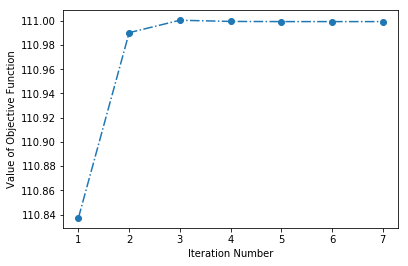

In [15]:
x = np.arange(1, (iter+1) +1)
plt.xticks(np.arange(1, 11, 1))
plt.xlabel("Iteration Number")
plt.ylabel("Value of Objective Function")
plt.plot(x, objective_value_list, "o-.")
plt.savefig("conv.png", bbox_inches="tight")

In [6]:
# Number of paths in A and B
print(A_list.shape[0])
print(B_list.shape[0])

5061
4939


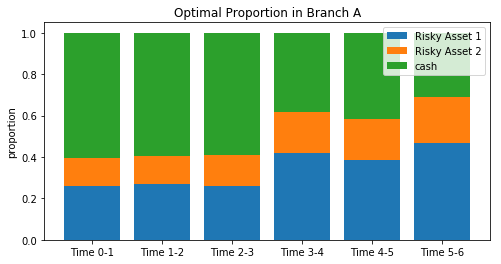

In [7]:
output_cash_ratio_A = opt_cash[A_list[0], :] / opt_wealth[A_list[0], :T]
output_cash_ratio_B = opt_cash[B_list[0], :] / opt_wealth[B_list[0], :T]

fig, axes = plt.subplots(figsize=(8, 4))
x = ["Time 0-1", "Time 1-2", "Time 2-3", "Time 3-4", "Time 4-5", "Time 5-6"]
w1 = np.concatenate((opt_units_0[0], opt_units_A[0]))
w2 = np.concatenate((opt_units_0[1], opt_units_A[1]))
w3 = output_cash_ratio_A
axes.bar(x, w1)
axes.bar(x, w2, bottom = w1)
axes.bar(x, w3, bottom = w1 + w2)
axes.legend(["Risky Asset 1", "Risky Asset 2", "cash"])
plt.ylabel("proportion")
plt.title("Optimal Proportion in Branch A")
plt.savefig("optimal_proportion_A.png")
plt.show()

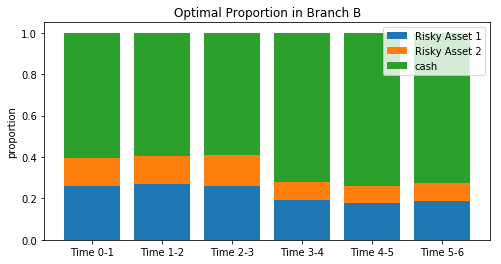

In [8]:
fig, axes = plt.subplots(figsize=(8, 4))
x = ["Time 0-1", "Time 1-2", "Time 2-3", "Time 3-4", "Time 4-5", "Time 5-6"]
w1 = np.concatenate((opt_units_0[0], opt_units_B[0]))
w2 = np.concatenate((opt_units_0[1], opt_units_B[1]))
w3 = output_cash_ratio_B
axes.bar(x, w1)
axes.bar(x, w2, bottom = w1)
axes.bar(x, w3, bottom = w1 + w2)
plt.ylabel("proportion")
plt.title("Optimal Proportion in Branch B")
axes.legend(["Risky Asset 1", "Risky Asset 2", "cash"])
plt.savefig("optimal_proportion_B.png")
plt.show()

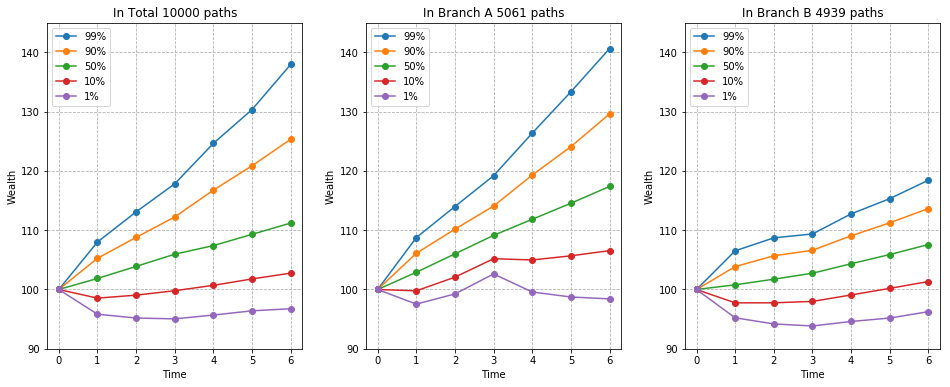

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,6))

plt.subplots_adjust(wspace=0.25)

y = np.percentile(opt_wealth, [99, 90, 50, 10, 1], axis=0)
x = np.arange(T + 1)
ax1.set_title('In Total 10000 paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wealth')
lineObjects = ax1.plot(x, y.T, "o-", label=range(5))
ax1.legend(lineObjects, ("99%", "90%", "50%", "10%", "1%"), loc='upper left')
ax1.set_ylim(90, 145)
ax1.grid(True, linestyle='--')
ax1.set_xticks(x)

y = np.percentile(opt_wealth[A_list,:], [99, 90, 50, 10, 1], axis=0)
x = np.arange(T + 1)
ax2.set_title('In Branch A 5061 paths')
ax2.set_xlabel('Time')
ax2.set_ylabel('Wealth')
ax2.set_ylim(90, 145)
ax2.grid(True, linestyle='--')
ax2.set_xticks(x)

lineObjects = ax2.plot(x, y.T, "o-", label=range(5))
ax2.legend(lineObjects, ("99%", "90%", "50%", "10%", "1%"), loc='upper left')

y = np.percentile(opt_wealth[B_list,:], [99, 90, 50, 10, 1], axis=0)
x = np.arange(T + 1)
ax3.set_title('In Branch B 4939 paths')
ax3.set_xlabel('Time')
ax3.set_ylabel('Wealth')
ax3.set_ylim(90, 145)
ax3.grid(True, linestyle='--')
ax3.set_xticks(x)

lineObjects = ax3.plot(x, y.T, "o-", label=range(5))
ax3.legend(lineObjects, ("99%", "90%", "50%", "10%", "1%"), loc='upper left')

plt.savefig("wealth_percentile.png")